In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import classification_report
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import *
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from wordcloud import WordCloud

/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
filename='X_train'
infile = open(filename,'rb')
X_train=pickle.load(infile)
infile.close()

filename='y_train'
infile = open(filename,'rb')
y_tr=pickle.load(infile)
infile.close()

filename='X_test'
infile = open(filename,'rb')
X_test=pickle.load(infile)
infile.close()

filename='y_test'
infile = open(filename,'rb')
y_test=pickle.load(infile)
infile.close()

In [3]:
#Unpickling
import pickle

infile = open('count_vect_BOW','rb')
count_vect=pickle.load(infile)
infile.close()

infile = open('Train_BOW_Std','rb')
X_train_Bow_standarized_data=pickle.load(infile)
infile.close()

infile = open('Test_BOW_Std','rb')
X_test_BOW_standarized_data=pickle.load(infile)
infile.close()

infile = open('tf_idf_vect_TF-IDF','rb')
tf_idf_vect = pickle.load(infile)
infile.close()

infile = open('Train_TFIDF_Std','rb')
X_train_tfidf_standarized_data=pickle.load(infile)
infile.close()

infile = open('Test_TFIDF_Std','rb')
X_test_tfidf_standarized_data=pickle.load(infile)
infile.close()

infile = open('Train_AvgW2V_std','rb')
X_train_AvgW2V_standarized_data=pickle.load(infile)
infile.close()


infile = open('Test_AvgW2V_std','rb')
X_test_AvgW2V_standarized_data=pickle.load(infile)
infile.close()

infile = open('TFIDF_W2V_Train_standarized_data','rb')
X_train_TFIDF_W2V_standarized_data=pickle.load(infile)
infile.close()


In [4]:
infile = open('TFIDF_W2V_Test_standarized_data','rb')
X_test_TFIDF_W2V_standarized_data=pickle.load(infile)
infile.close()

# GridSearch

In [5]:
def xgb_GRIDSEARCH(X_train,y_train):
    tuned_parameters = [{ "n_estimators": range(100,501,100),
                         "max_depth" : range(1,31,4),
                         "learning_rate" : [1e-5,1e-4,1e-3,1e-2,1e-1]
                    }]   
    xgb=XGBClassifier(booster ='gbtree')
    model= GridSearchCV(xgb,tuned_parameters, scoring = 'f1', cv=3,n_jobs=-1)
    model.fit(X_train, y_train)
    best_estimator= model.best_estimator_
    best_params = model.best_params_
    
    return best_estimator,best_params
   # return model


# Training_Testing Errors 

In [26]:
def Train_Test_Error(n_estimators,max_depth,learning_rate,X_train,y_train,X_test,y_test):
    xgb=XGBClassifier(booster ='gbtree',n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,n_jobs=-1)
    xgb_model = xgb.fit(X_train, y_train)

    #Training Error
    y_pred_tr = xgb_model.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)
    train_error = 1-acc_tr
    print('\n Train error is : {}'.format(train_error))

    #Test Error
    y_pred_ts = xgb_model.predict(X_test)
    acc_ts = accuracy_score(y_test, y_pred_ts)
    test_error = 1-acc_ts
    print('\n Test error is : {}'.format(test_error))
    
    return train_error,test_error,y_pred_ts,xgb_model

# CV_Error_Plot

In [33]:
def CV_Error_Plot(max_depth,learning_rate,X_Train,y_Train):
    n_estimators= [100,200,300,400,500]

    # empty list that will hold cv scores
    cv_scores = []

    for estimators in n_estimators:
        xgb=XGBClassifier(booster ='gbtree',n_estimators=estimators,max_depth=max_depth,learning_rate=learning_rate,n_jobs=-1)
        scores = cross_val_score(xgb, X_Train, y_Train, cv=3,scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_estimators = n_estimators[MSE.index(min(MSE))]
    print('\nThe optimal estimators is : {}'.format(optimal_estimators))

    plt.plot(n_estimators, MSE)

    for xy in zip(n_estimators, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('n_estimators')
    plt.ylabel('Misclassification Error')
    plt.show()
    print("the misclassification error for each estimators value is : ", np.round(MSE,3)) 
    return optimal_estimators

# Confusion Matrix

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# XGBoost_BOW

Using GridSearch

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
best_estimator_bow,best_params_bow = xgb_GRIDSEARCH(X_train_Bow_standarized_data,y_tr)

In [77]:
print best_estimator_bow
print best_params_bow 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
{'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 25}


Errors using Grid Search

In [14]:
train_error_bow,test_error_bow,y_pred_ts_bow,model_bow=Train_Test_Error(best_params_bow["n_estimators"],best_params_bow["max_depth"],best_params_bow["learning_rate"],X_train_Bow_standarized_data,y_tr,X_test_BOW_standarized_data,y_test)


 Train error is : 0.00247387780346

 Test error is : 0.0916410314838


Error Plot


The optimal estimators is : 500


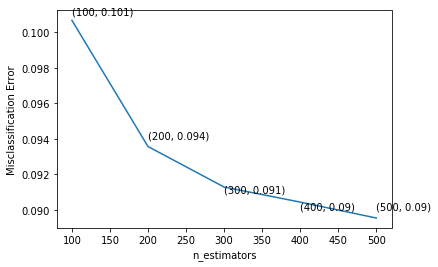

('the misclassification error for each estimators value is : ', array([0.101, 0.094, 0.091, 0.09 , 0.09 ]))


In [34]:
optimal_estimators_bow = CV_Error_Plot(best_params_bow["max_depth"],best_params_bow["learning_rate"],X_train_Bow_standarized_data,y_tr)


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.85      0.57      0.68      4557
          1       0.92      0.98      0.95     21774

avg / total       0.90      0.91      0.90     26331


  CONFUSION MATRIX
[[ 2615  1942]
 [  471 21303]]

  Plot of CONFUSION MATRIX


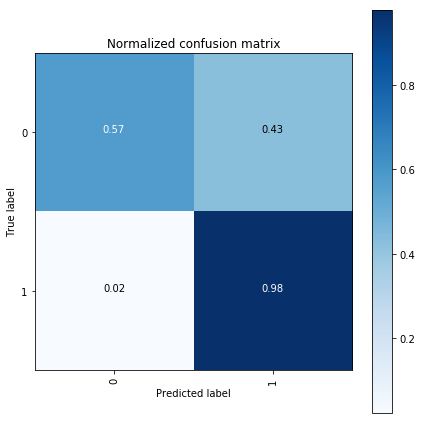

In [16]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_bow)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_bow)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [38]:
index_to_word = {v:k for k,v in count_vect.vocabulary_.items()}
weights3=[(index_to_word[i],model_bow.feature_importances_[i]) for i in np.nonzero(model_bow.feature_importances_)[0]]
weights4=sorted(weights3,reverse=True,key=lambda x: x[1])
dict_words= dict()
for i in range(len(weights4)):
    dict_words[weights4[i][0]] = weights4[i][1] 

In [52]:
print ('Postive Words::',weights4[0:20])
print ('Negative Words::',weights4[-20:])

('Postive Words::', [(u'like', 0.046983663), (u'tast', 0.0396799), (u'one', 0.027268492), (u'product', 0.025829367), (u'tri', 0.02191129), (u'flavor', 0.021453764), (u'good', 0.021187568), (u'would', 0.019390743), (u'get', 0.017169667), (u'use', 0.016803646), (u'buy', 0.012053705), (u'food', 0.010947326), (u'love', 0.010814228), (u'dont', 0.010631219), (u'make', 0.009616344), (u'order', 0.009233687), (u'amazon', 0.0091671385), (u'eat', 0.008426779), (u'time', 0.008401823), (u'realli', 0.008143946)])
('Negative Words::', [(u'thorough', 8.318637e-06), (u'thus', 8.318637e-06), (u'tight', 8.318637e-06), (u'titl', 8.318637e-06), (u'trap', 8.318637e-06), (u'tray', 8.318637e-06), (u'trial', 8.318637e-06), (u'upset', 8.318637e-06), (u'vacuum', 8.318637e-06), (u'versus', 8.318637e-06), (u'virtual', 8.318637e-06), (u'vita', 8.318637e-06), (u'wafer', 8.318637e-06), (u'wall', 8.318637e-06), (u'watermelon', 8.318637e-06), (u'west', 8.318637e-06), (u'whether', 8.318637e-06), (u'written', 8.318637e-0

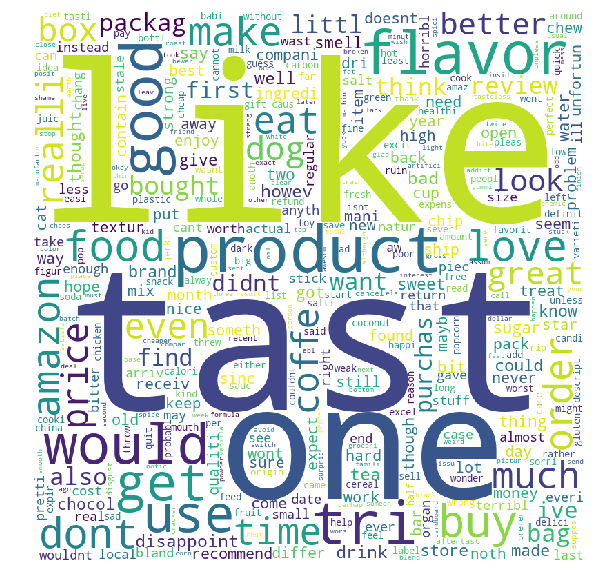

In [39]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=2000, 
                min_font_size = 10).generate_from_frequencies(dict_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# TFIDF

In [53]:
best_estimator_tfidf,best_params_tfidf = xgb_GRIDSEARCH(X_train_tfidf_standarized_data,y_tr)
print best_estimator_tfidf
print best_params_tfidf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
{'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 17}


Using GridSearch

In [56]:
train_error_tfidf,test_error_tfid,y_pred_ts_tfid,model_tfidf=Train_Test_Error(best_params_tfidf["n_estimators"],best_params_tfidf["max_depth"],best_params_tfidf["learning_rate"],X_train_tfidf_standarized_data,y_tr,X_test_tfidf_standarized_data,y_test)


 Train error is : 0.00480127600013

 Test error is : 0.0943374729406



The optimal estimators is : 500


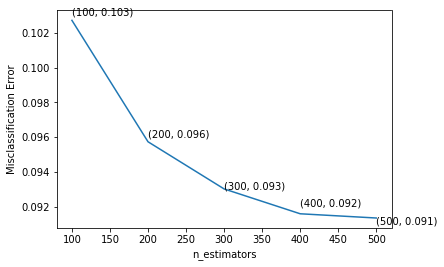

('the misclassification error for each estimators value is : ', array([0.103, 0.096, 0.093, 0.092, 0.091]))


In [59]:
optimal_estimators_tfidf = CV_Error_Plot(best_params_tfidf["max_depth"],best_params_tfidf["learning_rate"],X_train_tfidf_standarized_data,y_tr)


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.86      0.55      0.67      4557
          1       0.91      0.98      0.95     21774

avg / total       0.90      0.91      0.90     26331


  CONFUSION MATRIX
[[ 2488  2069]
 [  415 21359]]

  Plot of CONFUSION MATRIX


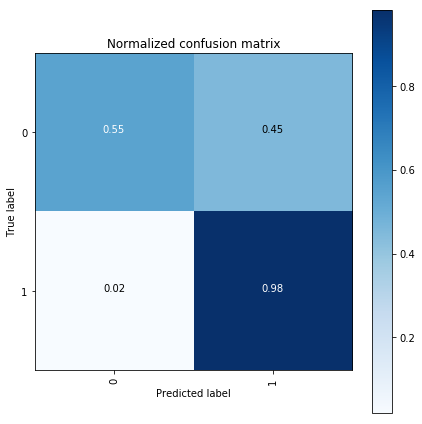

In [60]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_tfid)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_tfid)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [61]:
index_to_word = {v:k for k,v in tf_idf_vect.vocabulary_.items()}
weights3=[(index_to_word[i],model_bow.feature_importances_[i]) for i in np.nonzero(model_bow.feature_importances_)[0]]
weights4=sorted(weights3,reverse=True,key=lambda x: x[1])
dict_words= dict()
for i in range(len(weights4)):
    dict_words[weights4[i][0]] = weights4[i][1] 

print ('Postive Words::',weights4[0:20])
print ('Negative Words::',weights4[-20:])

('Postive Words::', [(u'like', 0.046983663), (u'tast', 0.0396799), (u'one', 0.027268492), (u'product', 0.025829367), (u'tri', 0.02191129), (u'flavor', 0.021453764), (u'good', 0.021187568), (u'would', 0.019390743), (u'get', 0.017169667), (u'use', 0.016803646), (u'buy', 0.012053705), (u'food', 0.010947326), (u'love', 0.010814228), (u'dont', 0.010631219), (u'make', 0.009616344), (u'order', 0.009233687), (u'amazon', 0.0091671385), (u'eat', 0.008426779), (u'time', 0.008401823), (u'realli', 0.008143946)])
('Negative Words::', [(u'thorough', 8.318637e-06), (u'thus', 8.318637e-06), (u'tight', 8.318637e-06), (u'titl', 8.318637e-06), (u'trap', 8.318637e-06), (u'tray', 8.318637e-06), (u'trial', 8.318637e-06), (u'upset', 8.318637e-06), (u'vacuum', 8.318637e-06), (u'versus', 8.318637e-06), (u'virtual', 8.318637e-06), (u'vita', 8.318637e-06), (u'wafer', 8.318637e-06), (u'wall', 8.318637e-06), (u'watermelon', 8.318637e-06), (u'west', 8.318637e-06), (u'whether', 8.318637e-06), (u'written', 8.318637e-0

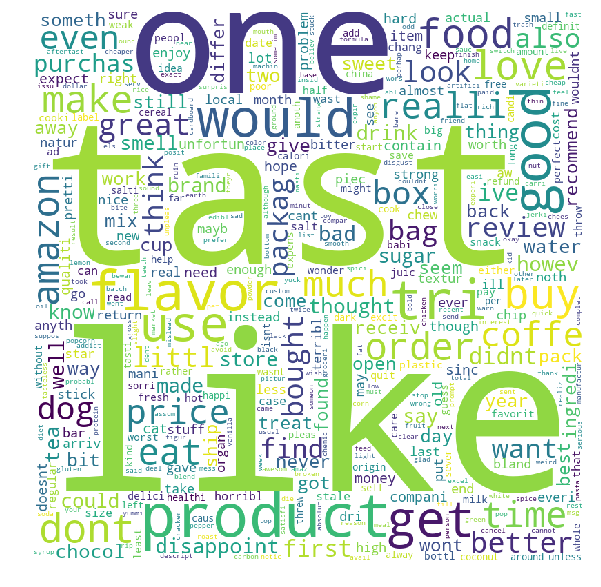

In [62]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=2000, 
                min_font_size = 10).generate_from_frequencies(dict_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# AVGW2V

GRIDSEEARCH

In [63]:
best_estimator_avgw2v,best_params_avgw2v = xgb_GRIDSEARCH(X_train_AvgW2V_standarized_data,y_tr)
print best_estimator_avgw2v
print best_params_avgw2v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
{'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 17}


Errors--Gridsearch

In [64]:
train_error_avgw2v,test_error_avgw2v,y_pred_ts_avgw2v,model_avgw2v=Train_Test_Error(best_params_avgw2v["n_estimators"],best_params_avgw2v["max_depth"],best_params_avgw2v["learning_rate"],X_train_AvgW2V_standarized_data,y_tr,X_test_AvgW2V_standarized_data,y_test)


 Train error is : 3.25510237297e-05

 Test error is : 0.153431316699


CV-ErrorPlot


The optimal estimators is : 500


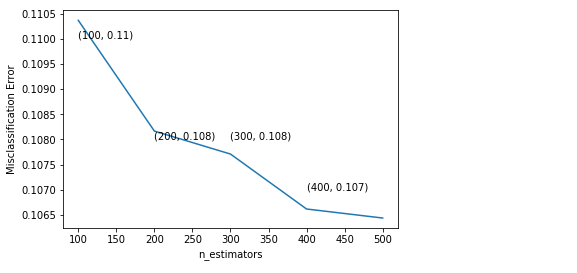

('the misclassification error for each estimators value is : ', array([0.11 , 0.108, 0.108, 0.107, 0.106]))


In [66]:
optimal_alpha_AvgW2V = CV_Error_Plot(best_params_avgw2v["max_depth"],best_params_avgw2v["learning_rate"],X_train_AvgW2V_standarized_data,y_tr)

Confusion Matrix


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.65      0.25      0.36      4557
          1       0.86      0.97      0.91     21774

avg / total       0.82      0.85      0.82     26331


  CONFUSION MATRIX
[[ 1119  3438]
 [  602 21172]]

  Plot of CONFUSION MATRIX


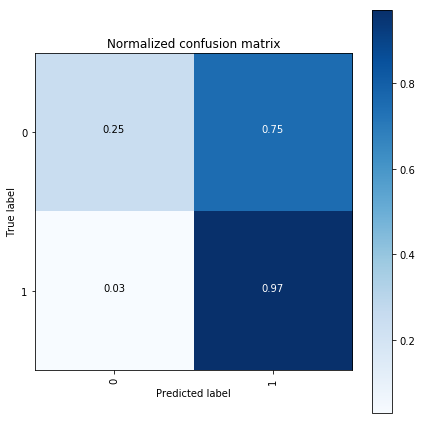

In [69]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_avgw2v)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_avgw2v)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

# tfidfw2v

GridSearch

In [70]:
best_estimator_TFIDF_W2V,best_params_TFIDF_W2V = xgb_GRIDSEARCH(X_train_TFIDF_W2V_standarized_data,y_tr)
print best_estimator_TFIDF_W2V
print best_params_TFIDF_W2V

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=17, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 17}


Errors- Grid search

In [71]:
train_error_TFIDF_W2V,test_error_TFIDF_W2V,y_pred_ts_TFIDF_W2V,model_TFIDF_W2V=\
Train_Test_Error(best_params_TFIDF_W2V["n_estimators"],best_params_TFIDF_W2V["max_depth"],best_params_TFIDF_W2V["learning_rate"],X_train_TFIDF_W2V_standarized_data,y_tr,X_test_TFIDF_W2V_standarized_data,y_test)


 Train error is : 3.25510237297e-05

 Test error is : 0.161748509362


CV-Error Plot


The optimal estimators is : 500


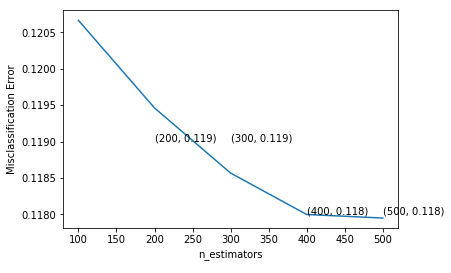

('the misclassification error for each estimators value is : ', array([0.121, 0.119, 0.119, 0.118, 0.118]))


In [72]:
optimal_alpha_tfidf = CV_Error_Plot(best_params_TFIDF_W2V["max_depth"],best_params_TFIDF_W2V["learning_rate"],X_train_TFIDF_W2V_standarized_data,y_tr)

Confusion Matrix


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.61      0.19      0.29      4557
          1       0.85      0.97      0.91     21774

avg / total       0.81      0.84      0.80     26331


  CONFUSION MATRIX
[[  850  3707]
 [  552 21222]]

  Plot of CONFUSION MATRIX


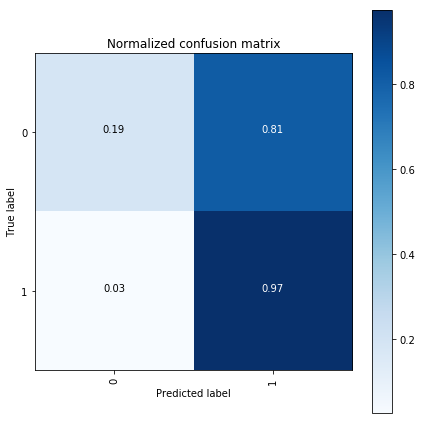

In [73]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_TFIDF_W2V)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_TFIDF_W2V)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

# Summary

In [76]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorization Model", "SearchMethood", "n_estimators","max_depth","learning_rate", "Training Error","Test Error"]

x.add_row(["BOW", "GRID", best_params_bow["n_estimators"], best_params_bow["max_depth"], best_params_bow["learning_rate"],round(train_error_bow*100,6),round(test_error_bow*100,2)])

x.add_row(["TFIDF", "GRID", best_params_tfidf["n_estimators"], best_params_tfidf["max_depth"], best_params_tfidf["learning_rate"],round(train_error_tfidf*100,6),round(test_error_tfid*100,2)])

x.add_row(["AvgW2V", "GRID", best_params_avgw2v["n_estimators"],best_params_avgw2v["max_depth"], best_params_avgw2v["learning_rate"],round(train_error_avgw2v*100,6),round(test_error_avgw2v*100,2)])

x.add_row(["TFIDF-W2V", "GRID", best_params_TFIDF_W2V["n_estimators"],best_params_TFIDF_W2V["max_depth"], best_params_TFIDF_W2V["learning_rate"],round(train_error_TFIDF_W2V*100,6),round(test_error_TFIDF_W2V*100,2)])


print(x)

+---------------------+---------------+--------------+-----------+---------------+----------------+------------+
| Vectorization Model | SearchMethood | n_estimators | max_depth | learning_rate | Training Error | Test Error |
+---------------------+---------------+--------------+-----------+---------------+----------------+------------+
|         BOW         |      GRID     |     500      |     25    |      0.1      |    0.247388    |    9.16    |
|        TFIDF        |      GRID     |     500      |     17    |      0.1      |    0.480128    |    9.43    |
|        AvgW2V       |      GRID     |     500      |     17    |      0.1      |    0.003255    |   15.34    |
|      TFIDF-W2V      |      GRID     |     400      |     17    |      0.1      |    0.003255    |   16.17    |
+---------------------+---------------+--------------+-----------+---------------+----------------+------------+


It is observed that Xgboost performed well with BOW,TFIDF and also the training error has reduced drastically when compared to other algorithms.